In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score

In [ ]:
# load data
train = pd.read_csv("/content/drive/My Drive/data/sign_mnist_train/sign_mnist_train.csv")
test = pd.read_csv("/content/drive/My Drive/data/sign_mnist_test/sign_mnist_test.csv")

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
# check if there is null in training data
train.isna().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [ ]:
# check if there is null in test data
test.isna().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

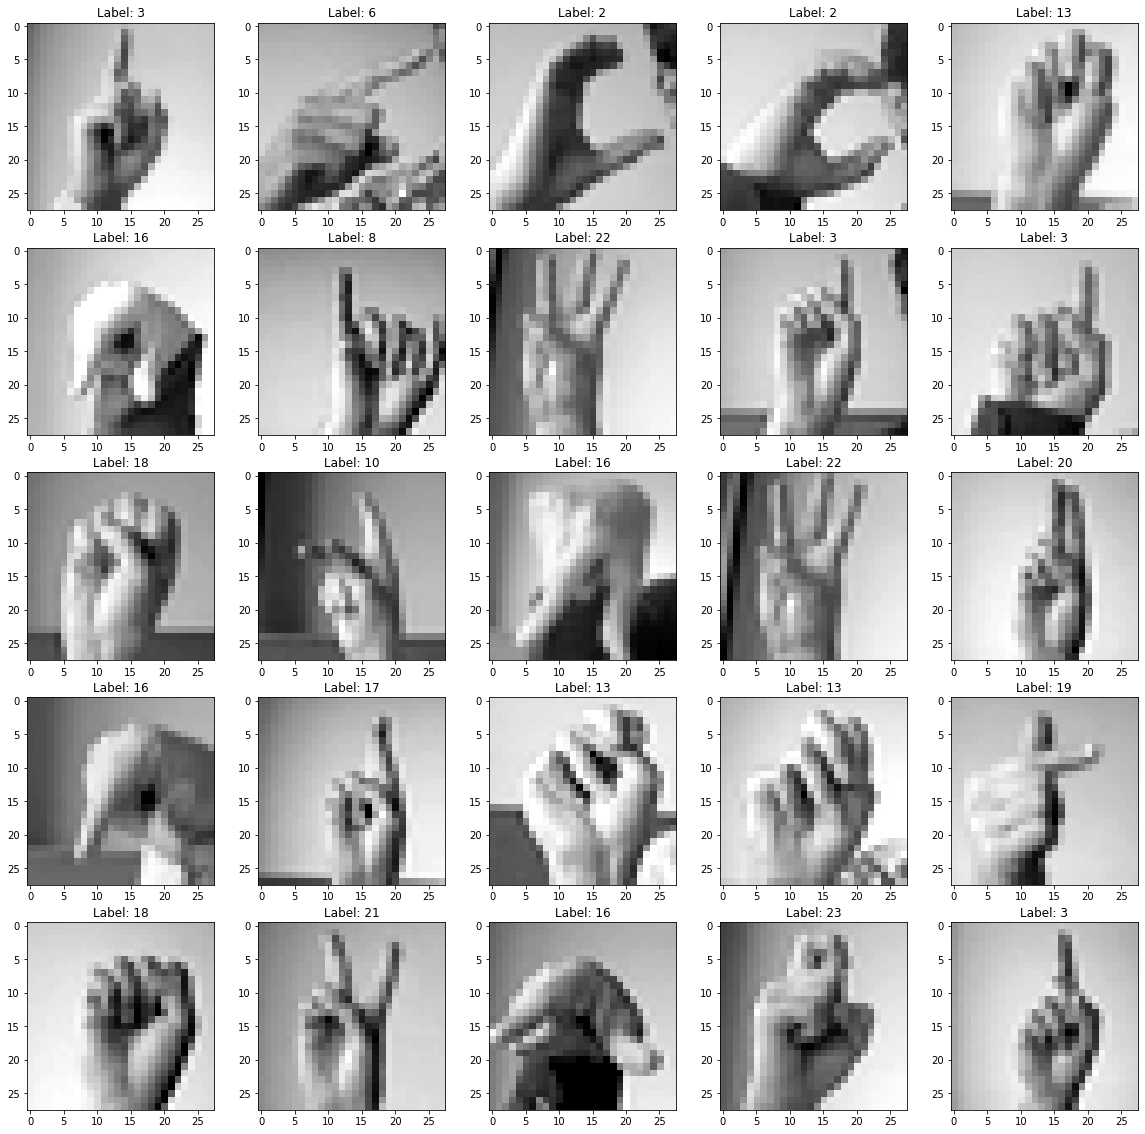

In [ ]:
# visualization
# figure size
plt.figure(figsize=(20, 20))
#subplot
for i in range(25):
    img = np.array(train.iloc[i, 1:].values).reshape(28, 28)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap= 'gray')
    plt.title('Label: ' + str(train['label'][i]))
plt.show()

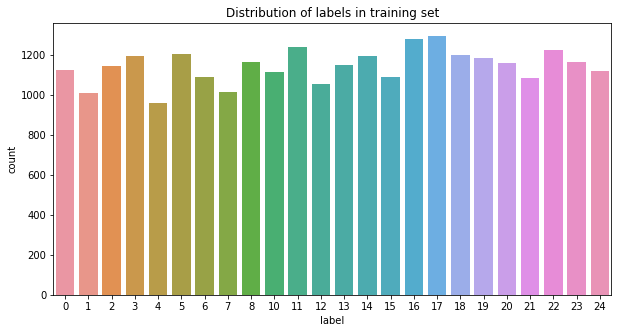

In [ ]:
# label distribution
plt.figure(figsize = (10, 5))
sns.countplot(x = 'label', data = train)
plt.title('Distribution of labels in training set')
plt.show()

In [ ]:
# get X_train, X_test
X_train = train.drop(labels = ["label"], axis = 1)
X_test = test.drop(labels = ["label"], axis = 1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (27455, 784)
X_test shape:  (7172, 784)


In [ ]:
# get Y_train and Y_test
Y_train = train["label"]
Y_test = test["label"]
print("Y_train shape: ", Y_train.shape)
print("Y_test shape: ", Y_test.shape)

Y_train shape:  (27455,)
Y_test shape:  (7172,)


In [ ]:
# reshape the training data
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1)
print("x_train shape: ", X_train.shape)
print("x_test shape: ", X_test.shape)

x_train shape:  (27455, 28, 28, 1)
x_test shape:  (7172, 28, 28, 1)


In [ ]:
# split training set and validation set
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2)
print("x_train shape: ", x_train.shape)
print("x_val shape: ", x_val.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)

x_train shape:  (21964, 28, 28, 1)
x_val shape:  (5491, 28, 28, 1)
y_train shape:  (21964,)
y_val shape:  (5491,)


In [ ]:
# data augmentation
generator = ImageDataGenerator(
    featurewise_center=False,    # set input mean to 0 over the dataset
    samplewise_center=False,    # set each sample mean to 0
    featurewise_std_normalization=False,   # divide inputs by std of the dataset
    samplewise_std_normalization=False,   # divide each input by its std
    rotation_range=10,     # degree range for random rotations
    zoom_range=0.1,    # range for random zoom
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,  # randomly flip inputs horizontally
    fill_mode="nearest",   # point outside the boundaries of the input are filled according to the given mode
    rescale=1./255     #  rescaling factor
)

# flow the training data
x_train_flow = generator.flow(x_train, y_train, batch_size=32)
# flow the validation data
val_generator = ImageDataGenerator(rescale=1./255)
x_validation_flow = val_generator.flow(x_val, y_val, batch_size=32)

In [ ]:
# reduce learning learning rate when a metric has stopped improving
# here we set the monitored quantity is val_accuracy, factor is 0.5, patientce is 5, then the learning rate will be reduced after 5 epochs
# with no improvement, and the factor for the learning rate to be reduced is 0.5, verbose is 1 means update messages and the lower bound on
# the lower bound of the learning rate is 0.00001
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [ ]:
# train the model
model = Sequential()
# add a 2D convolution layer
# the dimensionality of the output space is 32
# the height and width of the 2D convolution window is 3
# the activation function is relu
# the input shape is 28x28, and channel is 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
# add a max pooling layer to do downsampling
# the pooling window is 2x2
# how far the pooling window moves for each pooling step is 2
# "same" results in padding evenly to the left/right or up/down of the input such that the output has the same height/width
# dimension as the input
model.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
# add a batch normalization to maintain the mean output close to 0 and the output standard deviation close to 1
model.add(BatchNormalization())
# add a dropout layer
# the fraction of the input to be dropped is 0.25
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# flatten the input
model.add(Flatten())

# add a dense/fully-connected layer
# the dimensionality of the output space is 512
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=26, activation='softmax'))

# configure the model for training
# the optimizer is adam
# name of a loss function is binary_crossentropy
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()
print("length: ", len(model.layers))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 6, 6, 64)       

In [ ]:
# here I add the EarlyStopping for that when the monitored metric val loss has stopped improving, then the training will stop
history = model.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True),
                                                                                            learning_rate_reduction])

Epoch 1/100
687/687 [==============================] - 12s 17ms/step - loss: 1.0059 - accuracy: 0.6789 - val_loss: 0.3771 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 2/100
687/687 [==============================] - 11s 16ms/step - loss: 0.2877 - accuracy: 0.9032 - val_loss: 0.0716 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 3/100
687/687 [==============================] - 10s 15ms/step - loss: 0.1765 - accuracy: 0.9396 - val_loss: 0.0140 - val_accuracy: 0.9953 - lr: 0.0010
Epoch 4/100
687/687 [==============================] - 10s 15ms/step - loss: 0.1372 - accuracy: 0.9545 - val_loss: 0.0117 - val_accuracy: 0.9965 - lr: 0.0010
Epoch 5/100
687/687 [==============================] - 10s 15ms/step - loss: 0.1183 - accuracy: 0.9616 - val_loss: 0.0052 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 6/100
687/687 [==============================] - 10s 15ms/step - loss: 0.0957 - accuracy: 0.9684 - val_loss: 0.2509 - val_accuracy: 0.9253 - lr: 0.0010
Epoch 7/100
687/687 [==============================]

In [ ]:
# define the plot function
def plot_result(hist):
  accuracy = hist.history['accuracy']
  val_accuracy = hist.history['val_accuracy']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  epochs = range(len(accuracy))
  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(15, 8)
  ax[0].plot(epochs, accuracy, 'rx-', label='training accuracy')
  ax[0].plot(epochs, val_accuracy, 'bx-', label='validation accuracy')
  ax[0].set_title('Training vs. Validation accuray')
  ax[0].legend()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[1].plot(epochs, loss, 'rx-', label='training loss')
  ax[1].plot(epochs, val_loss, 'bx-', label='validation loss')
  ax[1].set_title('Training vs. Validation loss')
  ax[1].legend()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  plt.show()

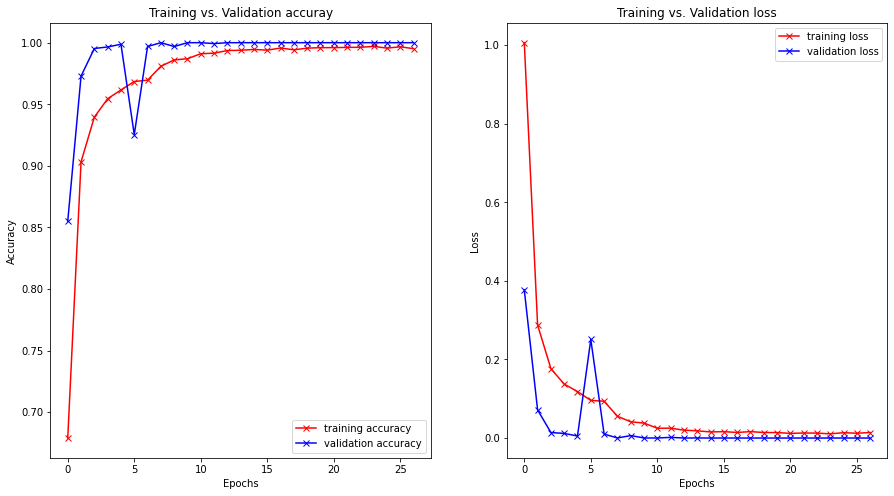

In [ ]:
# visualize the result
# plot the loss and accuracy for training set and validation set with the epochs
plot_result(history)

In [ ]:
# model without batch normalization
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model1.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model1.add(Dropout(0.25))

model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model1.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model1.add(Dropout(0.25))

model1.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model1.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model1.add(Dropout(0.25))

model1.add(Flatten())

model1.add(Dense(units=512, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(units=26, activation='softmax'))

model1.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model1.summary()
print("length: ", len(model1.layers))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 6, 6, 64)        

In [ ]:
history1 = model1.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True),
                                                                                            learning_rate_reduction])

Epoch 1/100
687/687 [==============================] - 14s 19ms/step - loss: 2.0581 - accuracy: 0.3609 - val_loss: 0.5104 - val_accuracy: 0.8410 - lr: 0.0010
Epoch 2/100
687/687 [==============================] - 11s 16ms/step - loss: 0.7088 - accuracy: 0.7570 - val_loss: 0.1667 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 3/100
687/687 [==============================] - 11s 16ms/step - loss: 0.4062 - accuracy: 0.8605 - val_loss: 0.0486 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 4/100
687/687 [==============================] - 10s 14ms/step - loss: 0.2939 - accuracy: 0.8976 - val_loss: 0.0316 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 5/100
687/687 [==============================] - 11s 17ms/step - loss: 0.2144 - accuracy: 0.9270 - val_loss: 0.0128 - val_accuracy: 0.9978 - lr: 0.0010
Epoch 6/100
687/687 [==============================] - 12s 17ms/step - loss: 0.1860 - accuracy: 0.9350 - val_loss: 0.0078 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 7/100
687/687 [==============================]

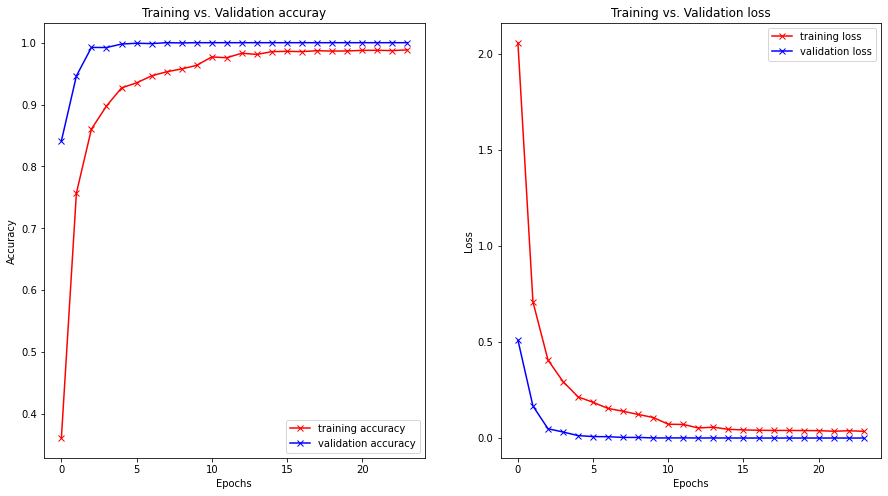

In [ ]:
# visualize the result for model1
plot_result(history1)

In [ ]:
# model without dropout layer
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model2.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model2.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model2.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model2.add(BatchNormalization())

model2.add(Flatten())

model2.add(Dense(units=512, activation='relu'))
model2.add(Dense(units=26, activation='softmax'))

model2.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model2.summary()
print("length: ", len(model2.layers))

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_49 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                     

In [ ]:
history2 = model2.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True),
                                                                                            learning_rate_reduction])

Epoch 1/100
687/687 [==============================] - 13s 18ms/step - loss: 0.4051 - accuracy: 0.8742 - val_loss: 0.1733 - val_accuracy: 0.9399 - lr: 0.0010
Epoch 2/100
687/687 [==============================] - 10s 15ms/step - loss: 0.0705 - accuracy: 0.9761 - val_loss: 0.0551 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 3/100
687/687 [==============================] - 10s 15ms/step - loss: 0.0538 - accuracy: 0.9826 - val_loss: 0.1945 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 4/100
687/687 [==============================] - 10s 15ms/step - loss: 0.0366 - accuracy: 0.9874 - val_loss: 0.0533 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 5/100
687/687 [==============================] - 10s 15ms/step - loss: 0.0436 - accuracy: 0.9860 - val_loss: 0.0615 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 6/100
687/687 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9917
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
687/687 [============================

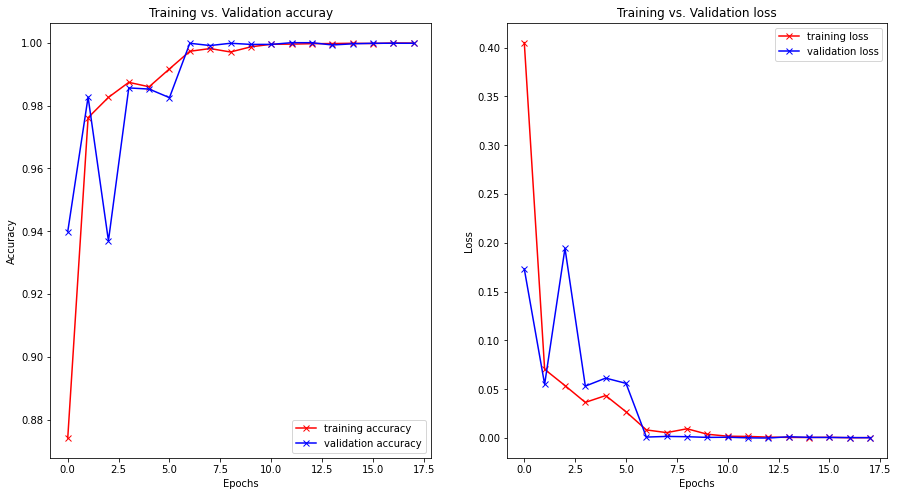

In [ ]:
# visualize the result for model2
plot_result(history2)

In [ ]:
# model with less layers
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model3.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model3.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model3.add(BatchNormalization())

model3.add(Flatten())

model3.add(Dense(units=26, activation='softmax'))

model3.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model3.summary()
print("length: ", len(model3.layers))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_11 (Bat  (None, 13, 13, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_52 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                     

In [ ]:
history3 = model3.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True),
                                                                                            learning_rate_reduction])

Epoch 1/100
687/687 [==============================] - 10s 15ms/step - loss: 0.7440 - accuracy: 0.7677 - val_loss: 0.4013 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 2/100
687/687 [==============================] - 10s 14ms/step - loss: 0.1814 - accuracy: 0.9440 - val_loss: 0.4030 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 3/100
687/687 [==============================] - 10s 15ms/step - loss: 0.1123 - accuracy: 0.9661 - val_loss: 0.0906 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 4/100
687/687 [==============================] - 12s 17ms/step - loss: 0.0781 - accuracy: 0.9753 - val_loss: 0.0844 - val_accuracy: 0.9709 - lr: 0.0010
Epoch 5/100
687/687 [==============================] - 10s 15ms/step - loss: 0.0605 - accuracy: 0.9810 - val_loss: 0.0553 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 6/100
687/687 [==============================] - 10s 14ms/step - loss: 0.0522 - accuracy: 0.9822 - val_loss: 0.6737 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 7/100
687/687 [==============================]

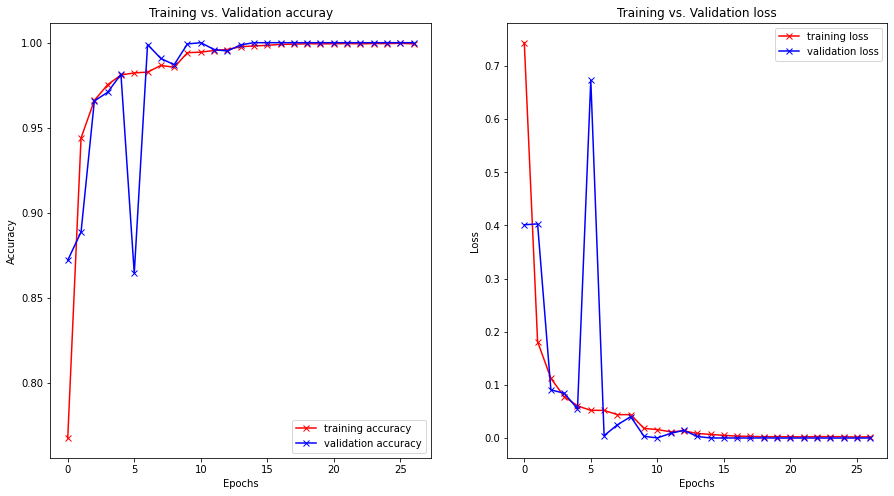

In [ ]:
# visualize the result for model3
plot_result(history3)

In [ ]:
# model with less layers
model4 = Sequential()
model4.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model4.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model4.add(BatchNormalization())
model4.add(Flatten())

model4.add(Dense(units=26, activation='softmax'))

model4.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model4.summary()
print("length: ", len(model4.layers))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_13 (Bat  (None, 13, 13, 128)      512       
 chNormalization)                                                
                                                                 
 flatten_18 (Flatten)        (None, 21632)             0         
                                                                 
 dense_35 (Dense)            (None, 26)                562458    
                                                                 
Total params: 564,250
Trainable params: 563,994
Non-t

In [ ]:
history4 = model4.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True),
                                                                                            learning_rate_reduction])

Epoch 1/100
687/687 [==============================] - 10s 14ms/step - loss: 0.8984 - accuracy: 0.7271 - val_loss: 0.3396 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 2/100
687/687 [==============================] - 9s 14ms/step - loss: 0.4656 - accuracy: 0.8526 - val_loss: 0.1679 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 3/100
687/687 [==============================] - 11s 16ms/step - loss: 0.3484 - accuracy: 0.8892 - val_loss: 0.1480 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 4/100
687/687 [==============================] - 16s 23ms/step - loss: 0.2981 - accuracy: 0.9041 - val_loss: 0.2652 - val_accuracy: 0.9135 - lr: 0.0010
Epoch 5/100
686/687 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.9169
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
687/687 [==============================] - 11s 15ms/step - loss: 0.2605 - accuracy: 0.9170 - val_loss: 0.1659 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 6/100
687/687 [=============================

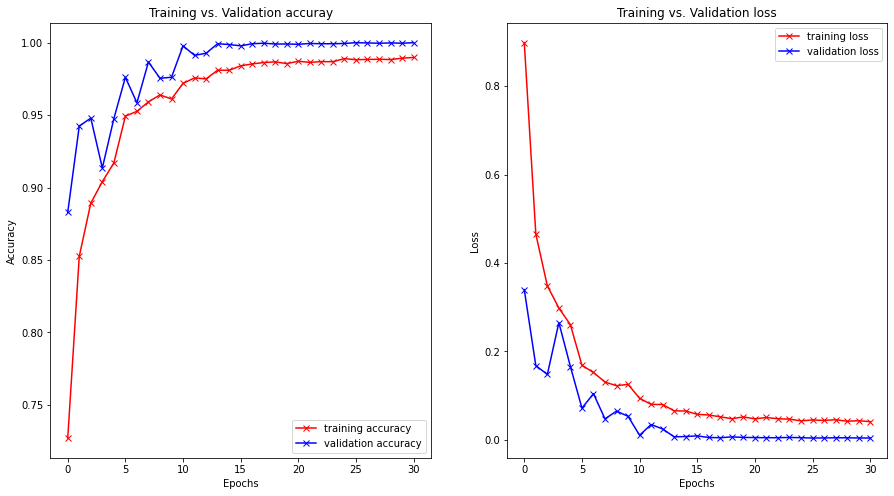

In [ ]:
# visualize the result for model4
plot_result(history4)

In [ ]:
# model with different order of layers
model5 = Sequential()
model5.add(Conv2D(filters=512, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model5.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model5.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model5.add(Dense(units=512, activation='relu'))
model5.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model5.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))
model5.add(Flatten())
model5.add(Dense(units=26, activation='softmax'))

model5.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model5.summary()
print("length: ", len(model5.layers))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 512)       5120      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       589952    
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        73792     
                                                                 
 dense (Dense)               (None, 22, 22, 512)       33280     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 512)      0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 512)        0         
 2D)                                                    

In [ ]:
history5 = model5.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True),
                                                                                            learning_rate_reduction])

Epoch 1/100
687/687 [==============================] - 24s 21ms/step - loss: 0.8021 - accuracy: 0.7516 - val_loss: 0.2404 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 2/100
687/687 [==============================] - 15s 21ms/step - loss: 0.2947 - accuracy: 0.9039 - val_loss: 0.0490 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 3/100
687/687 [==============================] - 15s 22ms/step - loss: 0.1947 - accuracy: 0.9401 - val_loss: 0.0928 - val_accuracy: 0.9652 - lr: 0.0010
Epoch 4/100
686/687 [============================>.] - ETA: 0s - loss: 0.1558 - accuracy: 0.9503
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
687/687 [==============================] - 14s 21ms/step - loss: 0.1557 - accuracy: 0.9502 - val_loss: 0.0807 - val_accuracy: 0.9740 - lr: 0.0010
Epoch 5/100
687/687 [==============================] - 14s 21ms/step - loss: 0.0624 - accuracy: 0.9790 - val_loss: 0.0026 - val_accuracy: 0.9991 - lr: 5.0000e-04
Epoch 6/100
687/687 [========================

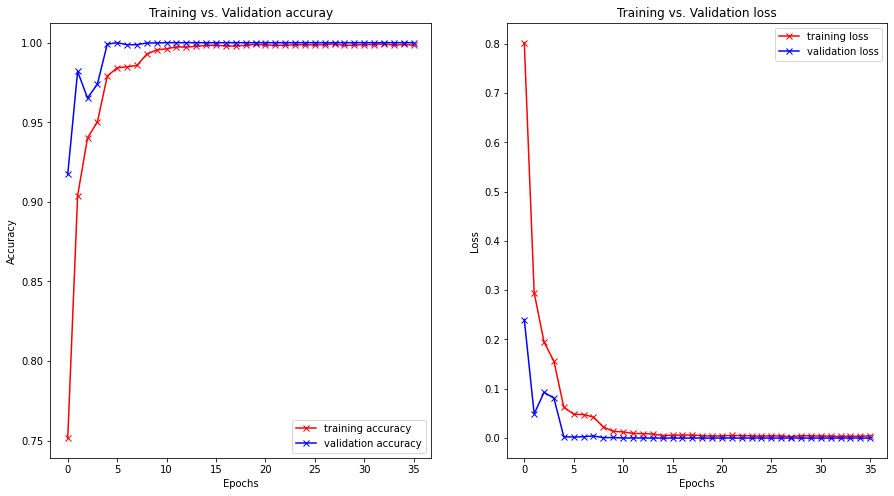

In [ ]:
# visualize the result for model5
plot_result(history5)

In [ ]:
# remove the dropout layers
modelNew = Sequential()
modelNew.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
modelNew.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

modelNew.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
modelNew.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

modelNew.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
modelNew.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))

modelNew.add(Flatten())

modelNew.add(Dense(units=512, activation='relu'))
modelNew.add(Dense(units=26, activation='softmax'))

modelNew.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
modelNew.summary()

modelNew.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
history6 = modelNew.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True),
                                                                                           learning_rate_reduction])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 2, 2, 128)      

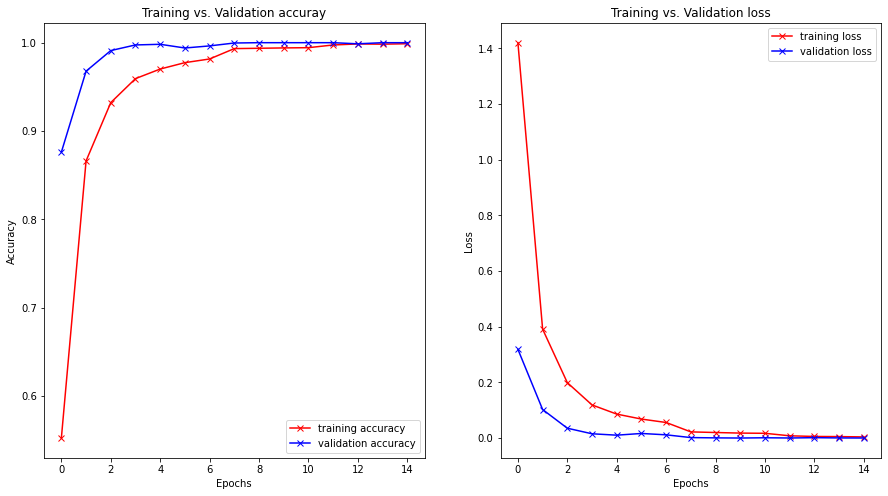

In [ ]:
plot_result(history6)

In [ ]:
# prediction on testing set
def prediction(model):
  pred = model.predict(X_test)
  pred = np.argmax(pred, axis=1)

  acc = accuracy_score(Y_test, pred)
  print(f"the accruacy is {acc}")

In [ ]:
# accuracy of the models
models = [model, model1, model2, model3, model4, model5, modelNew]
for model in models:
  prediction(model)

225/225 [==============================] - 0s 2ms/step
the accruacy is 0.980340211935304
225/225 [==============================] - 0s 2ms/step
the accruacy is 0.9838259899609593
225/225 [==============================] - 1s 2ms/step
the accruacy is 0.9431121026213051
225/225 [==============================] - 0s 2ms/step
the accruacy is 0.7516731734523145
225/225 [==============================] - 0s 2ms/step
the accruacy is 0.6019241494701617
225/225 [==============================] - 2s 7ms/step
the accruacy is 0.7097044060234244
225/225 [==============================] - 1s 3ms/step
the accruacy is 0.980340211935304


In [ ]:
# when optimizer is RMSprop
bestmodel = Sequential()
bestmodel.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel.add(Dropout(0.25))

bestmodel.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel.add(Dropout(0.25))

bestmodel.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel.add(Dropout(0.25))

bestmodel.add(Flatten())

bestmodel.add(Dense(units=512, activation='relu'))
bestmodel.add(Dropout(0.25))
bestmodel.add(Dense(units=26, activation='softmax'))

# use a different optimizer RMSprop
bestmodel.compile(optimizer='RMSprop', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
hist = bestmodel.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True)])

Epoch 1/100
687/687 [==============================] - 26s 19ms/step - loss: 1.9347 - accuracy: 0.3958 - val_loss: 0.4820 - val_accuracy: 0.8405
Epoch 2/100
687/687 [==============================] - 13s 19ms/step - loss: 0.7000 - accuracy: 0.7618 - val_loss: 0.1339 - val_accuracy: 0.9652
Epoch 3/100
687/687 [==============================] - 15s 21ms/step - loss: 0.4025 - accuracy: 0.8611 - val_loss: 0.0526 - val_accuracy: 0.9812
Epoch 4/100
687/687 [==============================] - 14s 21ms/step - loss: 0.2854 - accuracy: 0.9030 - val_loss: 0.0248 - val_accuracy: 0.9933
Epoch 5/100
687/687 [==============================] - 13s 20ms/step - loss: 0.2194 - accuracy: 0.9264 - val_loss: 0.0132 - val_accuracy: 0.9989
Epoch 6/100
687/687 [==============================] - 14s 21ms/step - loss: 0.1714 - accuracy: 0.9437 - val_loss: 0.0078 - val_accuracy: 0.9985
Epoch 7/100
687/687 [==============================] - 13s 19ms/step - loss: 0.1606 - accuracy: 0.9474 - val_loss: 0.0045 - val_ac

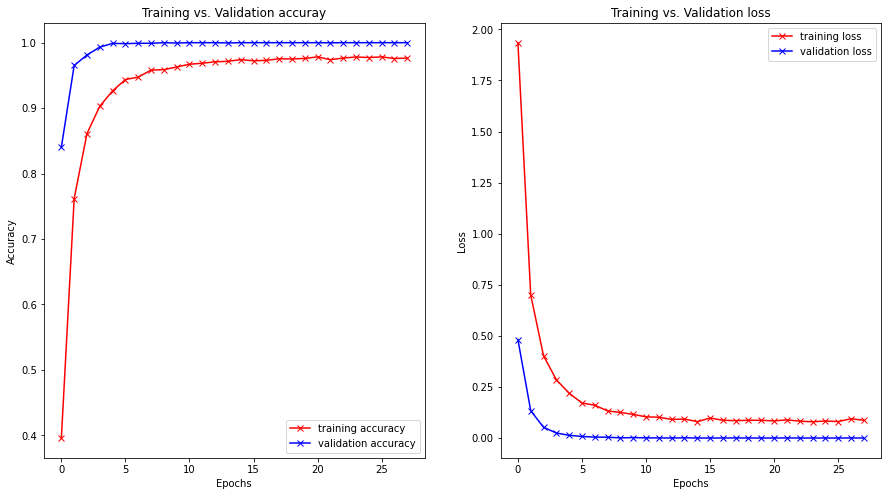

In [ ]:
# plot the result with different optimizers
plot_result(hist)

In [ ]:
prediction(bestmodel)

225/225 [==============================] - 1s 3ms/step
the accruacy is 0.9804796430563302


In [ ]:
# when optimizer is SGD
bestmodel1 = Sequential()
bestmodel1.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel1.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel1.add(Dropout(0.25))

bestmodel1.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel1.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel1.add(Dropout(0.25))

bestmodel1.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel1.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel1.add(Dropout(0.25))

bestmodel1.add(Flatten())

bestmodel1.add(Dense(units=512, activation='relu'))
bestmodel1.add(Dropout(0.25))
bestmodel1.add(Dense(units=26, activation='softmax'))

# use optimizer SGD
bestmodel1.compile(optimizer='SGD', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
hist1 = bestmodel1.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True)])

Epoch 1/100
687/687 [==============================] - 46s 65ms/step - loss: 3.2061 - accuracy: 0.0473 - val_loss: 3.1888 - val_accuracy: 0.0676
Epoch 2/100
687/687 [==============================] - 41s 60ms/step - loss: 3.0822 - accuracy: 0.0932 - val_loss: 2.9334 - val_accuracy: 0.1712
Epoch 4/100
687/687 [==============================] - 46s 67ms/step - loss: 2.8048 - accuracy: 0.1659 - val_loss: 2.5094 - val_accuracy: 0.3019
Epoch 5/100
687/687 [==============================] - 44s 64ms/step - loss: 2.5129 - accuracy: 0.2410 - val_loss: 2.1458 - val_accuracy: 0.4176
Epoch 6/100
687/687 [==============================] - 44s 64ms/step - loss: 2.2325 - accuracy: 0.3130 - val_loss: 1.7657 - val_accuracy: 0.5128
Epoch 7/100
687/687 [==============================] - 44s 64ms/step - loss: 1.9993 - accuracy: 0.3742 - val_loss: 1.4563 - val_accuracy: 0.6075
Epoch 8/100
687/687 [==============================] - 42s 61ms/step - loss: 1.7806 - accuracy: 0.4338 - val_loss: 1.2246 - val_ac

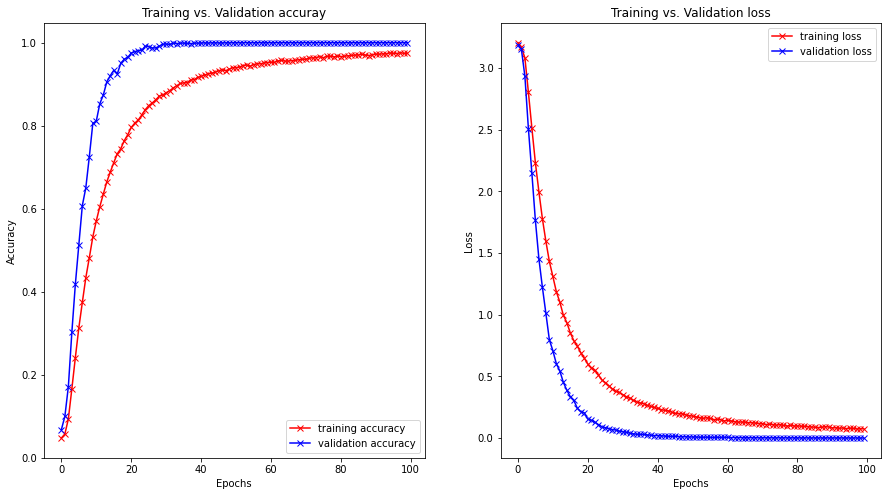

In [ ]:
# plot the results when optimizer is SGD
plot_result(hist1)

In [ ]:
prediction(bestmodel1)

225/225 [==============================] - 3s 15ms/step
the accruacy is 0.9682097044060234


In [ ]:
# when optimizer is Adagrad
bestmodel2 = Sequential()
bestmodel2.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel2.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel2.add(Dropout(0.25))

bestmodel2.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel2.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel2.add(Dropout(0.25))

bestmodel2.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel2.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel2.add(Dropout(0.25))

bestmodel2.add(Flatten())

bestmodel2.add(Dense(units=512, activation='relu'))
bestmodel2.add(Dropout(0.25))
bestmodel2.add(Dense(units=26, activation='softmax'))

bestmodel2.compile(optimizer='Adagrad', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
hist2 = bestmodel2.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True)])

Epoch 1/100
687/687 [==============================] - 10s 14ms/step - loss: 3.2509 - accuracy: 0.0414 - val_loss: 3.2357 - val_accuracy: 0.0443
Epoch 2/100
687/687 [==============================] - 9s 14ms/step - loss: 3.2150 - accuracy: 0.0454 - val_loss: 3.2118 - val_accuracy: 0.0426
Epoch 3/100
687/687 [==============================] - 9s 13ms/step - loss: 3.1992 - accuracy: 0.0449 - val_loss: 3.1991 - val_accuracy: 0.0443
Epoch 4/100
687/687 [==============================] - 9s 13ms/step - loss: 3.1896 - accuracy: 0.0458 - val_loss: 3.1915 - val_accuracy: 0.0443
Epoch 5/100
687/687 [==============================] - 9s 13ms/step - loss: 3.1852 - accuracy: 0.0483 - val_loss: 3.1863 - val_accuracy: 0.0446
Epoch 6/100
687/687 [==============================] - 9s 14ms/step - loss: 3.1836 - accuracy: 0.0495 - val_loss: 3.1839 - val_accuracy: 0.0444
Epoch 7/100
687/687 [==============================] - 9s 13ms/step - loss: 3.1794 - accuracy: 0.0524 - val_loss: 3.1802 - val_accuracy

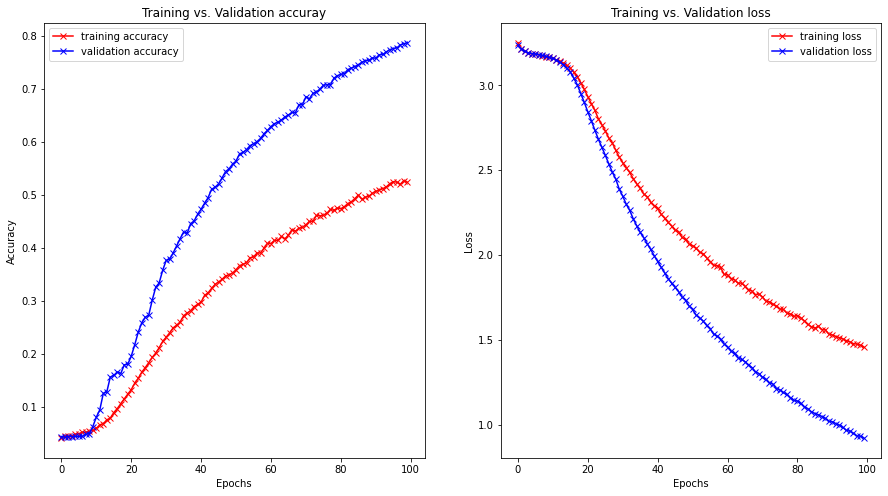

In [ ]:
# plot the results when optimizer is Adagrad
plot_result(hist2)

In [ ]:
# when optimizer is Adam
bestmodelAdam = Sequential()
bestmodelAdam.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodelAdam.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodelAdam.add(Dropout(0.25))

bestmodelAdam.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodelAdam.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodelAdam.add(Dropout(0.25))

bestmodelAdam.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodelAdam.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodelAdam.add(Dropout(0.25))

bestmodelAdam.add(Flatten())

bestmodelAdam.add(Dense(units=512, activation='relu'))
bestmodelAdam.add(Dropout(0.25))
bestmodelAdam.add(Dense(units=26, activation='softmax'))

bestmodelAdam.compile(optimizer='Adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
histAdam = bestmodelAdam.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True)])

Epoch 1/100
687/687 [==============================] - 43s 61ms/step - loss: 2.1697 - accuracy: 0.3266 - val_loss: 0.5693 - val_accuracy: 0.7964
Epoch 2/100
687/687 [==============================] - 46s 66ms/step - loss: 0.7396 - accuracy: 0.7442 - val_loss: 0.1833 - val_accuracy: 0.9499
Epoch 3/100
687/687 [==============================] - 44s 63ms/step - loss: 0.4431 - accuracy: 0.8470 - val_loss: 0.1038 - val_accuracy: 0.9707
Epoch 4/100
687/687 [==============================] - 44s 64ms/step - loss: 0.2928 - accuracy: 0.8986 - val_loss: 0.0462 - val_accuracy: 0.9878
Epoch 5/100
687/687 [==============================] - 44s 64ms/step - loss: 0.2252 - accuracy: 0.9232 - val_loss: 0.0177 - val_accuracy: 0.9956
Epoch 6/100
687/687 [==============================] - 43s 63ms/step - loss: 0.1773 - accuracy: 0.9385 - val_loss: 0.0226 - val_accuracy: 0.9925
Epoch 7/100
687/687 [==============================] - 45s 66ms/step - loss: 0.1591 - accuracy: 0.9446 - val_loss: 0.0057 - val_ac

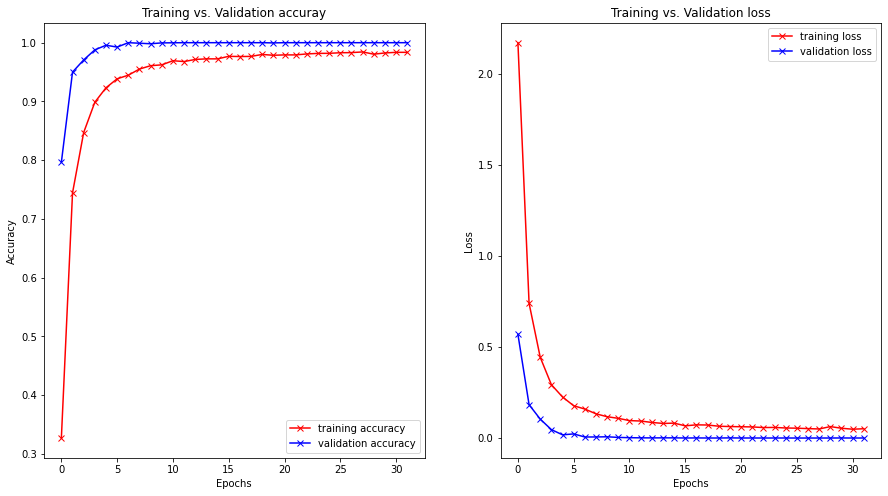

In [ ]:
plot_result(histAdam)

In [ ]:
prediction(bestmodelAdam)

225/225 [==============================] - 3s 15ms/step
the accruacy is 0.9881483547127718


In [ ]:
# then we choose optimizer Adam
# optimzer with learning rate equals 0.00001
bestmodel3 = Sequential()
bestmodel3.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel3.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel3.add(Dropout(0.25))

bestmodel3.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel3.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel3.add(Dropout(0.25))

bestmodel3.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel3.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel3.add(Dropout(0.25))

bestmodel3.add(Flatten())

bestmodel3.add(Dense(units=512, activation='relu'))
bestmodel3.add(Dropout(0.25))
bestmodel3.add(Dense(units=26, activation='softmax'))

bestmodel3.compile(optimizer=Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
hist3 = bestmodel3.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True)])

Epoch 1/100
687/687 [==============================] - 11s 15ms/step - loss: 3.2344 - accuracy: 0.0448 - val_loss: 3.2267 - val_accuracy: 0.0408 - lr: 1.0000e-05
Epoch 2/100
687/687 [==============================] - 11s 16ms/step - loss: 3.1998 - accuracy: 0.0447 - val_loss: 3.2035 - val_accuracy: 0.0432 - lr: 1.0000e-05
Epoch 3/100
687/687 [==============================] - 12s 18ms/step - loss: 3.1855 - accuracy: 0.0480 - val_loss: 3.1922 - val_accuracy: 0.0432 - lr: 1.0000e-05
Epoch 4/100
687/687 [==============================] - 11s 15ms/step - loss: 3.1795 - accuracy: 0.0508 - val_loss: 3.1844 - val_accuracy: 0.0433 - lr: 1.0000e-05
Epoch 5/100
687/687 [==============================] - 13s 18ms/step - loss: 3.1704 - accuracy: 0.0542 - val_loss: 3.1749 - val_accuracy: 0.0483 - lr: 1.0000e-05
Epoch 6/100
687/687 [==============================] - 11s 16ms/step - loss: 3.1578 - accuracy: 0.0640 - val_loss: 3.1614 - val_accuracy: 0.0803 - lr: 1.0000e-05
Epoch 7/100
687/687 [=======

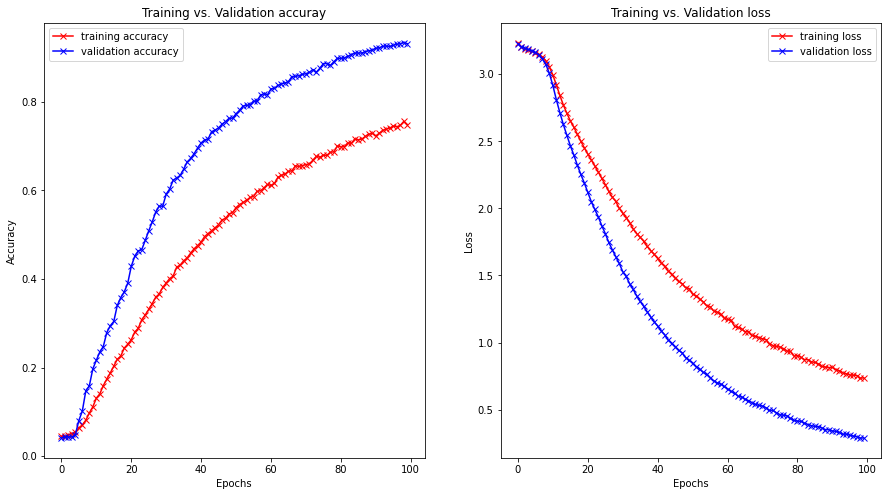

In [ ]:
plot_result(hist3)

In [ ]:
# then we choose optimizer Adam
# optimzer with learning rate equals 0.0001
bestmodel4 = Sequential()
bestmodel4.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel4.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel4.add(Dropout(0.25))

bestmodel4.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel4.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel4.add(Dropout(0.25))

bestmodel4.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel4.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel4.add(Dropout(0.25))

bestmodel4.add(Flatten())

bestmodel4.add(Dense(units=512, activation='relu'))
bestmodel4.add(Dropout(0.25))
bestmodel4.add(Dense(units=26, activation='softmax'))

bestmodel4.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
hist4 = bestmodel4.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True)])

Epoch 1/100
687/687 [==============================] - 10s 14ms/step - loss: 3.1826 - accuracy: 0.0543 - val_loss: 3.1154 - val_accuracy: 0.1023
Epoch 2/100
687/687 [==============================] - 11s 16ms/step - loss: 2.7257 - accuracy: 0.1825 - val_loss: 2.0759 - val_accuracy: 0.4061
Epoch 3/100
687/687 [==============================] - 10s 14ms/step - loss: 2.1062 - accuracy: 0.3414 - val_loss: 1.4550 - val_accuracy: 0.5908
Epoch 4/100
687/687 [==============================] - 10s 14ms/step - loss: 1.7095 - accuracy: 0.4570 - val_loss: 1.0716 - val_accuracy: 0.6864
Epoch 5/100
687/687 [==============================] - 10s 14ms/step - loss: 1.4478 - accuracy: 0.5348 - val_loss: 0.7983 - val_accuracy: 0.7918
Epoch 6/100
687/687 [==============================] - 10s 14ms/step - loss: 1.2670 - accuracy: 0.5881 - val_loss: 0.6391 - val_accuracy: 0.8383
Epoch 7/100
687/687 [==============================] - 10s 14ms/step - loss: 1.0968 - accuracy: 0.6369 - val_loss: 0.5157 - val_ac

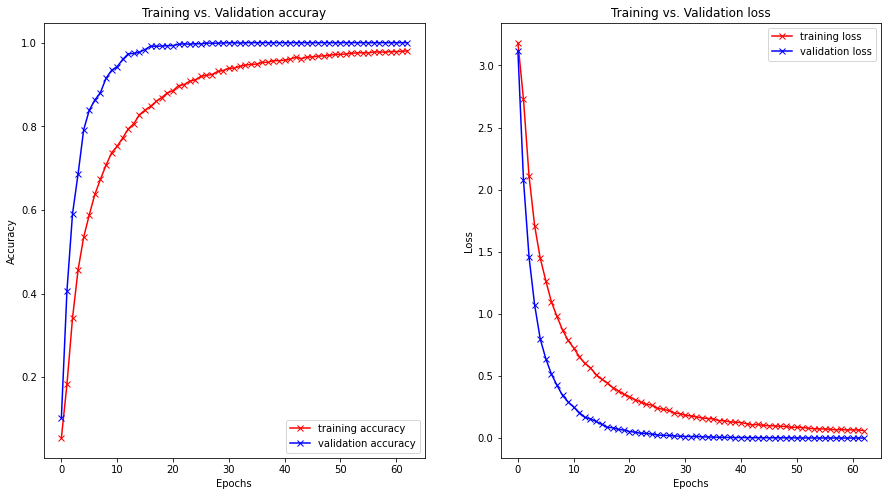

In [ ]:
plot_result(hist4)

In [ ]:
# optimzer with learning rate equals 0.01
bestmodel5 = Sequential()
bestmodel5.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel5.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel5.add(Dropout(0.25))

bestmodel5.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel5.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel5.add(Dropout(0.25))

bestmodel5.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel5.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel5.add(Dropout(0.25))

bestmodel5.add(Flatten())

bestmodel5.add(Dense(units=512, activation='relu'))
bestmodel5.add(Dropout(0.25))
bestmodel5.add(Dense(units=26, activation='softmax'))

bestmodel5.compile(optimizer=Adam(learning_rate=0.01), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
hist5 = bestmodel5.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True)])

Epoch 1/100
687/687 [==============================] - 21s 17ms/step - loss: 3.1931 - accuracy: 0.0428 - val_loss: 3.1816 - val_accuracy: 0.0455
Epoch 2/100
687/687 [==============================] - 11s 16ms/step - loss: 3.1802 - accuracy: 0.0438 - val_loss: 3.1809 - val_accuracy: 0.0432
Epoch 3/100
687/687 [==============================] - 13s 18ms/step - loss: 3.1788 - accuracy: 0.0450 - val_loss: 3.1799 - val_accuracy: 0.0432
Epoch 4/100
687/687 [==============================] - 11s 15ms/step - loss: 3.1779 - accuracy: 0.0444 - val_loss: 3.1779 - val_accuracy: 0.0455
Epoch 5/100
687/687 [==============================] - 11s 16ms/step - loss: 3.1780 - accuracy: 0.0459 - val_loss: 3.1787 - val_accuracy: 0.0432
Epoch 6/100
687/687 [==============================] - 11s 16ms/step - loss: 3.1775 - accuracy: 0.0479 - val_loss: 3.1802 - val_accuracy: 0.0428
Epoch 7/100
687/687 [==============================] - 11s 16ms/step - loss: 3.1777 - accuracy: 0.0437 - val_loss: 3.1789 - val_ac

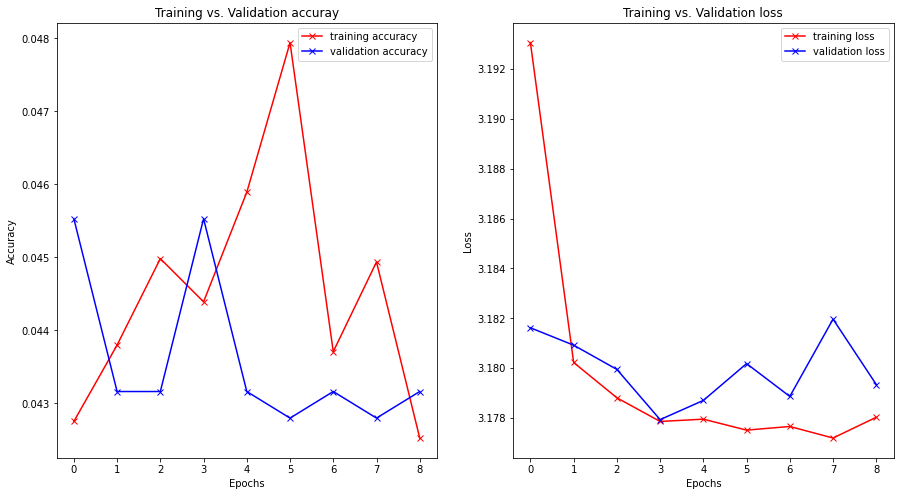

In [ ]:
plot_result(hist5)

In [ ]:
# optimizer Adam with scheduled learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

bestmodel6 = Sequential()
bestmodel6.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel6.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel6.add(Dropout(0.25))

bestmodel6.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel6.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel6.add(Dropout(0.25))

bestmodel6.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
bestmodel6.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='same'))
bestmodel6.add(Dropout(0.25))

bestmodel6.add(Flatten())

bestmodel6.add(Dense(units=512, activation='relu'))
bestmodel6.add(Dropout(0.25))
bestmodel6.add(Dense(units=26, activation='softmax'))

bestmodel6.compile(optimizer=Adam(learning_rate=lr_schedule), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
hist6 = bestmodel6.fit(x_train_flow, validation_data=x_validation_flow, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                                                                                          restore_best_weights=True)])

Epoch 1/100
687/687 [==============================] - 10s 14ms/step - loss: 2.0720 - accuracy: 0.3531 - val_loss: 0.4763 - val_accuracy: 0.8643
Epoch 2/100
687/687 [==============================] - 9s 14ms/step - loss: 0.7158 - accuracy: 0.7566 - val_loss: 0.1695 - val_accuracy: 0.9479
Epoch 3/100
687/687 [==============================] - 9s 14ms/step - loss: 0.4285 - accuracy: 0.8542 - val_loss: 0.0690 - val_accuracy: 0.9836
Epoch 4/100
687/687 [==============================] - 9s 14ms/step - loss: 0.2988 - accuracy: 0.8964 - val_loss: 0.0299 - val_accuracy: 0.9931
Epoch 5/100
687/687 [==============================] - 9s 13ms/step - loss: 0.2346 - accuracy: 0.9196 - val_loss: 0.0193 - val_accuracy: 0.9951
Epoch 6/100
687/687 [==============================] - 9s 13ms/step - loss: 0.2018 - accuracy: 0.9313 - val_loss: 0.0105 - val_accuracy: 0.9993
Epoch 7/100
687/687 [==============================] - 9s 13ms/step - loss: 0.1622 - accuracy: 0.9459 - val_loss: 0.0060 - val_accuracy

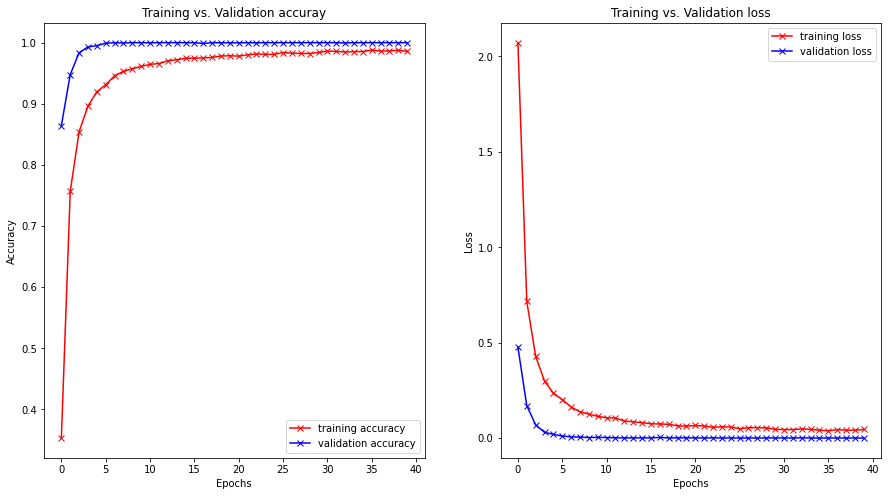

In [ ]:
plot_result(hist6)

In [ ]:
prediction(bestmodel6)

225/225 [==============================] - 0s 2ms/step
the accruacy is 0.989542665923034


In [ ]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix

predict = np.argmax(bestmodel6.predict(X_test), axis=1)
print(classification_report(Y_test, predict))

225/225 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.97      0.99       432
           2       0.95      1.00      0.97       310
           3       1.00      1.00      1.00       245
           4       0.98      1.00      0.99       498
           5       1.00      1.00      1.00       247
           6       1.00      0.97      0.99       348
           7       1.00      0.95      0.97       436
           8       0.99      1.00      1.00       288
          10       1.00      0.98      0.99       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394
          13       1.00      1.00      1.00       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       0.95      1.00      0.97       164
          17       1.00   

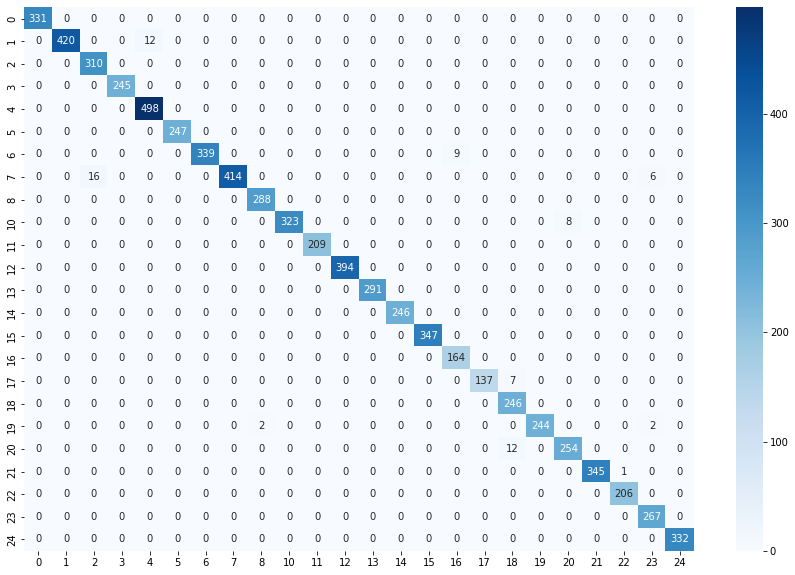

In [ ]:
# display confusion matrix
matrix = confusion_matrix(Y_test, predict)
matrix = pd.DataFrame(matrix , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
plt.figure(figsize=(15, 10))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='')
plt.show()

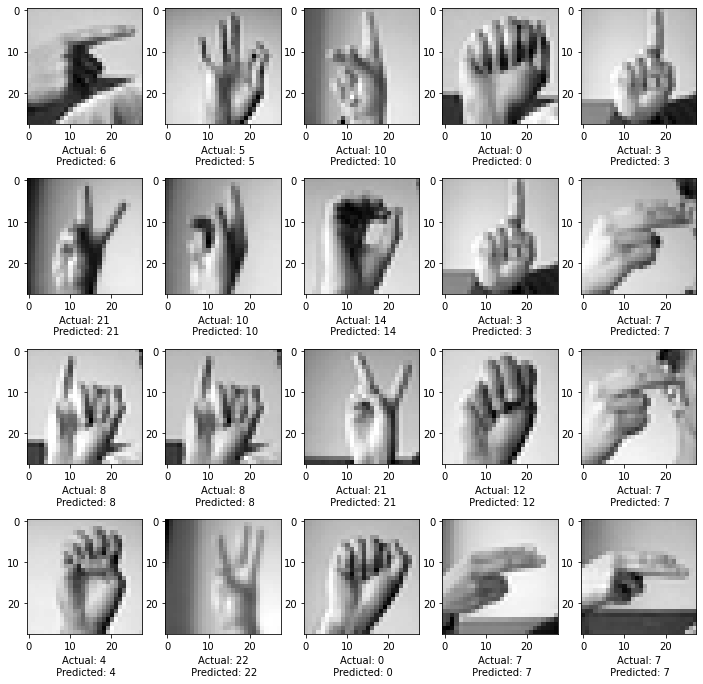

In [ ]:
# show some images
plt.figure(figsize=(12, 12))
for i in range(20):
  img = np.array(test.iloc[i, 1:].values).reshape(28, 28)
  plt.subplot(4, 5, i+1)
  plt.imshow(img, cmap='gray')
  plt.xlabel(f"Actual: {Y_test[i]}\n Predicted: {predict[i]}")

plt.show()